# GrIS melt causality

Author: Ziqi Yin

Last modified: 2025 Sep 16

Description: Causal inference of Greenland Ice Sheet summer surface melt
- Method: PCMCI+
- Period: 1940-1969
- Frequency: monthly
- Region: ablation zone
- Variables: SWn, LWn, SH, LH
- Source: MAR v3.14, 10km

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec

import sys
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
from copy import deepcopy

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gpdc import GPDC

import tifffile

import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

# https://github.com/hhuangwx/cmaps
import cmaps

import geopandas as gp
import regionmask

# For regridding
import os
import ESMF

import datetime
import pandas as pd

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
# Function to remove seasonal mean and divide by seasonal standard deviation
def anomalize(dataseries, divide_by_std=True, reference_bounds=None, cycle_length=12, return_cycle=False):
    if reference_bounds is None:
        reference_bounds = (0, len(dataseries))

    anomaly = np.copy(dataseries)
    for t in range(cycle_length):
        if return_cycle:
            anomaly[t::cycle_length] = dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
        else:
            anomaly[t::cycle_length] -= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
            if divide_by_std:
                anomaly[t::cycle_length] /= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].std(axis=0)
    return anomaly

In [3]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

## Load data

### MAR melt and SMB

In [4]:
MAR_melt_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['ME'][:,0,:,:].sel(TIME=slice('1940-01-01','2014-12-31'))
MAR_smb_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['SMB'][:,0,:,:].sel(TIME=slice('1940-01-01','2014-12-31'))
mar_lon = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['LON'] #[-180, 180]
mar_lat = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['LAT']

### SEB fluxes

In [5]:
# Daily mean surface SEB fluxes
MAR_SWd_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['SWD'].sel(TIME=slice('1940-01-01','2014-12-31')) #[W/m2]
MAR_albedo_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['AL2'][:,0,:,:].sel(TIME=slice('1940-01-01','2014-12-31'))
MAR_LWd_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['LWD'].sel(TIME=slice('1940-01-01','2014-12-31'))
MAR_TS_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['ST2'][:,0,:,:].sel(TIME=slice('1940-01-01','2014-12-31')) #[degree C]
MAR_SH_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['SHF'].sel(TIME=slice('1940-01-01','2014-12-31'))
MAR_LH_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['LHF'].sel(TIME=slice('1940-01-01','2014-12-31'))

In [6]:
MAR_SWu_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['SWU'].sel(TIME=slice('1940-01-01','2014-12-31')) #[W/m2]
MAR_LWu_daily_1940_2014 = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['LWU'].sel(TIME=slice('1940-01-01','2014-12-31')) #[W/m2]

In [7]:
MAR_SWn_daily_1940_2014 = MAR_SWd_daily_1940_2014 - MAR_SWu_daily_1940_2014
MAR_LWn_daily_1940_2014 = MAR_LWd_daily_1940_2014 - MAR_LWu_daily_1940_2014

### Area

In [8]:
MAR_area = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['AREA'] * 1e6 # Grid-cell area [m2], all 100km2

### Ablation zone

In [9]:
year = MAR_smb_daily_1940_2014.TIME.dt.year
MAR_smb_yearly_1940_2014 = MAR_smb_daily_1940_2014.groupby(year).sum() #[mm/yr]
MAR_smb_yearly_mean_1940_1969 = MAR_smb_yearly_1940_2014.sel(year=slice('1940','1969')).mean(dim='year')

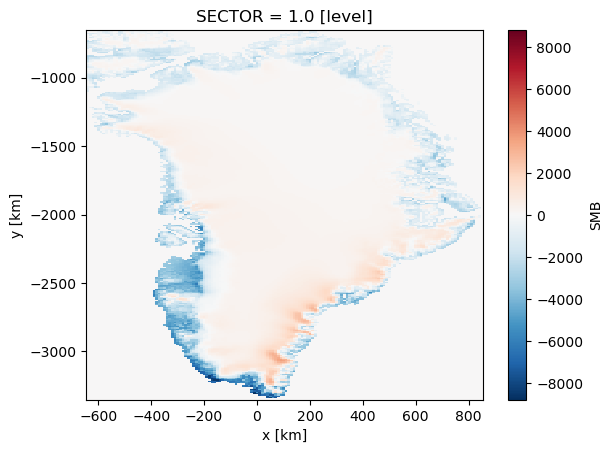

In [10]:
MAR_smb_yearly_mean_1940_1969.plot();

In [11]:
# Save the averaged SMB field as netcdf file
mar_y = MAR_smb_yearly_mean_1940_1969.y.values
mar_x = MAR_smb_yearly_mean_1940_1969.x.values
df = xr.DataArray(MAR_smb_yearly_mean_1940_1969.values, dims=['y','x'], coords=[('y', mar_y),('x', mar_x)], name='SMB', attrs=dict(longname='MAR mean SMB averaged over 1940-1969', units='mm/yr'))
df.to_netcdf(home_dir+'2023-GrIS-melt-causality/data/MAR/MAR_smb_yearly_mean_1940_1969.nc')

In [12]:
# Select grid points that have <0 smb
fill_value = MAR_smb_yearly_mean_1940_1969[0,0].values
MAR_ablation_mask_1940_1969 = xr.where(MAR_smb_yearly_mean_1940_1969 == fill_value, np.NaN, MAR_smb_yearly_mean_1940_1969)
MAR_ablation_mask_1940_1969 = xr.where(MAR_ablation_mask_1940_1969 < 0, 1, 0)  #

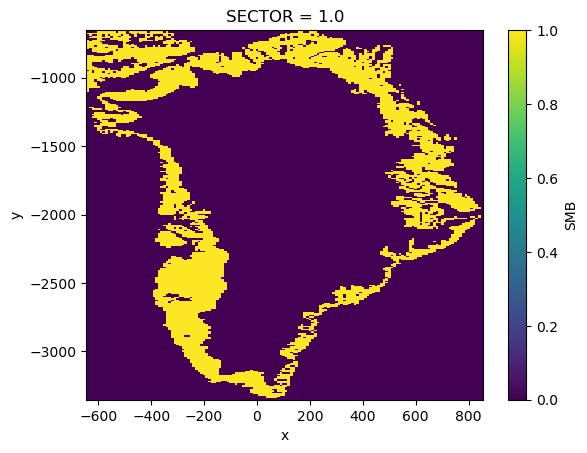

In [13]:
MAR_ablation_mask_1940_1969.plot();

### Mask

#### MAR grid

In [14]:
#MAR_landmask = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/FGRN055_Masks.nc')['LSM_GR'] #Land sea mask (land:1, sea:0)
MAR_icemask = xr.open_dataset('/glade/derecho/scratch/ziqiyin/data/MAR/MARv3.14.0-10km-daily-ERA5-1940_2022.nc')['MSK'] #Ice mask
#MAR_icemask = xr.where(racmo_icemask==4, 1, 0)
#MAR_GrIS_mask = MAR_landmask * MAR_icemask # [only 0 or 1]
MAR_GrIS_mask = MAR_icemask/100

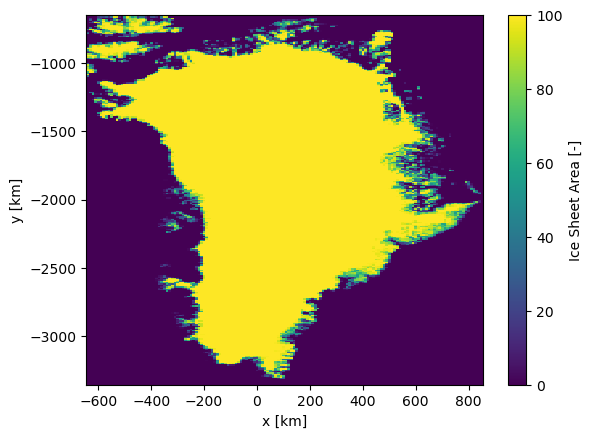

In [15]:
MAR_icemask.plot();

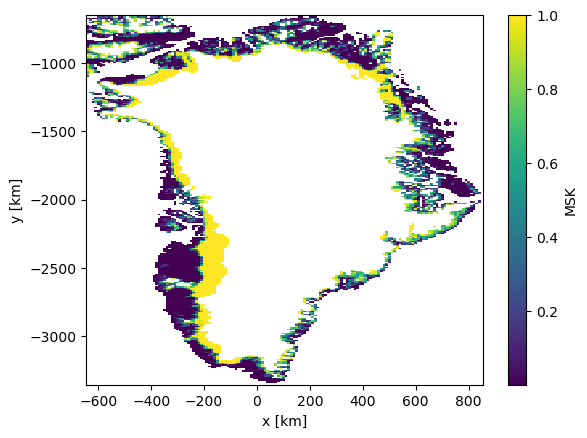

In [16]:
MAR_GrIS_ablation_mask = MAR_GrIS_mask * MAR_ablation_mask_1940_1969.values
MAR_GrIS_ablation_mask.where(MAR_GrIS_ablation_mask>0).plot();

#### Regridded from RACMO

In [17]:
racmo_lon = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/snowmelt.1958-2022.BN_RACMO2.3p2_ERA5_3h_FGRN055.MM.nc')['lon'].values #[-180, 180]
racmo_lat = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/snowmelt.1958-2022.BN_RACMO2.3p2_ERA5_3h_FGRN055.MM.nc')['lat'].values

racmo_icemask = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/FGRN055_Masks.nc')['Promicemask'] #Ice mask(only ice sheet)
racmo_icemask = xr.where(racmo_icemask==4, 1, 0)

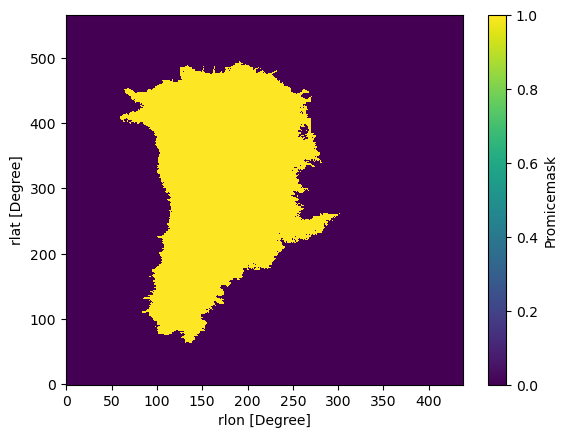

In [18]:
racmo_icemask.plot();

In [19]:
# RACMO
racmo_centers = np.stack((racmo_lon, racmo_lat))

# MAR
mar_centers = np.stack((mar_lon.values, mar_lat.values))

In [20]:
def regrid_grid_to_grid(centers_gridin, var_gridin, centers_gridout):

    # Input grid
    gridin = ESMF.Grid(np.array(var_gridin.T.shape), staggerloc=[ESMF.StaggerLoc.CENTER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridin_lon = gridin.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridin_lat = gridin.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridin_lon[...] = centers_gridin[0]
    gridin_lat[...] = centers_gridin[1]
    srcfield = ESMF.Field(gridin)
    srcfield.data[:] = var_gridin.T

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.BILINEAR,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data

    return outfield_data

In [21]:
racmo2mar_GrIS_mask = regrid_grid_to_grid(racmo_centers, racmo_icemask.T, mar_centers)

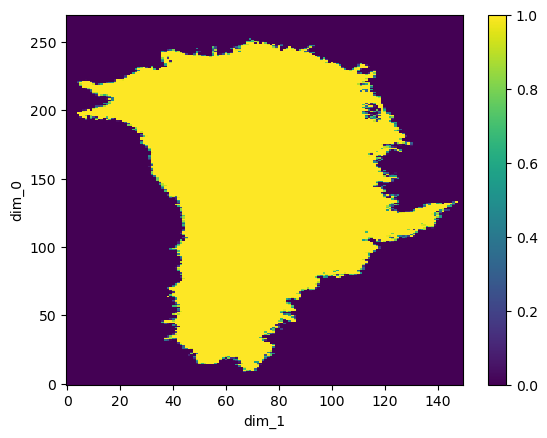

In [22]:
xr.DataArray(racmo2mar_GrIS_mask).plot(); # <1 values due to the bilinear method

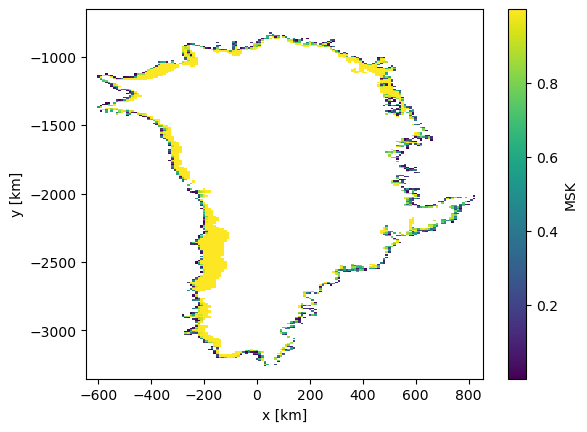

In [23]:
MAR_GrIS_ablation_mask = MAR_GrIS_ablation_mask * racmo2mar_GrIS_mask
MAR_GrIS_ablation_mask.where(MAR_GrIS_ablation_mask>0).plot();

In [26]:
# Save ablation mask as netcdf file
df = xr.DataArray(MAR_GrIS_ablation_mask.where(MAR_GrIS_ablation_mask>0).values, dims=['y','x'], coords=[('y', mar_y),('x', mar_x)], name='SMB', attrs=dict(longname='MAR mean ablation mask over 1940-1969', units=''))
df.to_netcdf(home_dir+'2023-GrIS-melt-causality/data/MAR/MAR_ablation_mask_yearly_mean_1940_1969.nc')

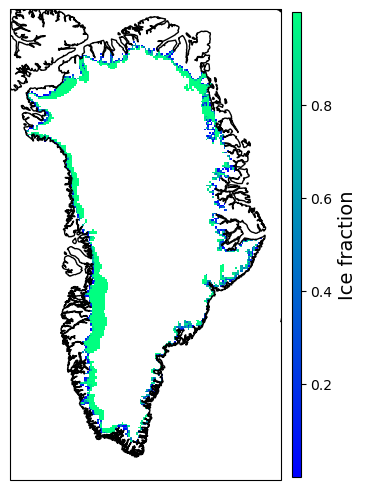

In [23]:
fig = plt.figure(figsize = (3.5,6.2))
gs=GridSpec(1,1)
plt.rcParams['axes.titlepad'] =14

#---------------------------------------------1----------------------------------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84])
ax1.coastlines(resolution='10m', zorder=7)

im1 = ax1.pcolormesh(mar_lon, mar_lat, MAR_GrIS_ablation_mask.where(MAR_GrIS_ablation_mask>0), cmap='winter', transform=ccrs.PlateCarree())
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax1 = fig.add_axes([0.93, 0.121, 0.025, 0.75])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical')
cb1.set_label(label='Ice fraction', size=14)
cb1.ax.tick_params(labelsize=10)


plt.subplots_adjust(wspace=0.2)
plt.savefig(home_dir+'2023-GrIS-melt-causality/plot/MAR/Ice_fraction_ablation_MAR_RACMOmask_historical_1940_1969.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

## Calculate

In [24]:
#days_in_month = RACMO_melt_monthly_1940_2014.time.dt.days_in_month # [day]
MAR_GrIS_melt_daily_1940_1969 = (MAR_melt_daily_1940_2014.sel(TIME=slice('1940-01-01','1969-12-31')) * MAR_GrIS_ablation_mask.values * MAR_area.values).sum(dim=['x','y']) / 1e3 # [m3/day]
MAR_GrIS_melt_daily_1940_1969 = MAR_GrIS_melt_daily_1940_1969 * 1e3 # [kg/day]

In [23]:
#MAR_GrIS_melt_daily_1979_2019_noleap = MAR_GrIS_melt_daily_1979_2019.where(MAR_GrIS_melt_daily_1979_2019.TIME.dt.date!=np.datetime64('1980-02-29'), drop=True)

In [25]:
MAR_GrIS_melt_monthly_1940_1969 = np.zeros(30*12)

for i in range(1940,1970):
    MAR_GrIS_melt_daily_1940_1969_singleyear = MAR_GrIS_melt_daily_1940_1969.where(MAR_GrIS_melt_daily_1940_1969.TIME.dt.year == i, drop=True)
    MAR_GrIS_melt_monthly_1940_1969[(i-1940)*12:(i-1940)*12+12] = MAR_GrIS_melt_daily_1940_1969_singleyear.groupby(MAR_GrIS_melt_daily_1940_1969_singleyear.TIME.dt.month).mean().values #[kg/day]

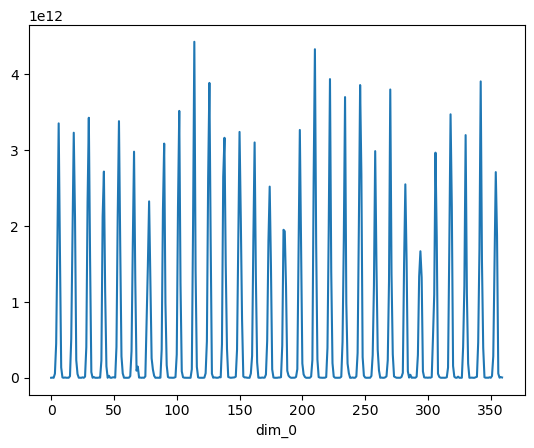

In [26]:
xr.DataArray(MAR_GrIS_melt_monthly_1940_1969).plot();

In [27]:
# SEB
MAR_GrIS_SWn_daily_1940_1969 = (MAR_SWn_daily_1940_2014.sel(TIME=slice('1940-01-01','1969-12-31')) * MAR_GrIS_ablation_mask.values * MAR_area.values).sum(dim=['x','y']) / (MAR_GrIS_ablation_mask * MAR_area.values).sum(dim=['x','y'])
MAR_GrIS_LWn_daily_1940_1969 = (MAR_LWn_daily_1940_2014.sel(TIME=slice('1940-01-01','1969-12-31')) * MAR_GrIS_ablation_mask.values * MAR_area.values).sum(dim=['x','y']) / (MAR_GrIS_ablation_mask * MAR_area.values).sum(dim=['x','y'])
MAR_GrIS_SH_daily_1940_1969 = (MAR_SH_daily_1940_2014.sel(TIME=slice('1940-01-01','1969-12-31')) * MAR_GrIS_ablation_mask.values * MAR_area.values).sum(dim=['x','y']) / (MAR_GrIS_ablation_mask * MAR_area.values).sum(dim=['x','y'])
MAR_GrIS_LH_daily_1940_1969 = (MAR_LH_daily_1940_2014.sel(TIME=slice('1940-01-01','1969-12-31')) * MAR_GrIS_ablation_mask.values * MAR_area.values).sum(dim=['x','y']) / (MAR_GrIS_ablation_mask * MAR_area.values).sum(dim=['x','y'])

In [28]:
MAR_GrIS_SWn_monthly_1940_1969 = np.zeros(30*12)
MAR_GrIS_LWn_monthly_1940_1969 = np.zeros(30*12)
MAR_GrIS_SH_monthly_1940_1969 = np.zeros(30*12)
MAR_GrIS_LH_monthly_1940_1969 = np.zeros(30*12)

for i in range(1940,1970):
    MAR_GrIS_SWn_daily_1940_1969_singleyear = MAR_GrIS_SWn_daily_1940_1969.where(MAR_GrIS_SWn_daily_1940_1969.TIME.dt.year == i, drop=True)
    MAR_GrIS_LWn_daily_1940_1969_singleyear = MAR_GrIS_LWn_daily_1940_1969.where(MAR_GrIS_LWn_daily_1940_1969.TIME.dt.year == i, drop=True)
    MAR_GrIS_SH_daily_1940_1969_singleyear = MAR_GrIS_SH_daily_1940_1969.where(MAR_GrIS_SH_daily_1940_1969.TIME.dt.year == i, drop=True)
    MAR_GrIS_LH_daily_1940_1969_singleyear = MAR_GrIS_LH_daily_1940_1969.where(MAR_GrIS_LH_daily_1940_1969.TIME.dt.year == i, drop=True)
    MAR_GrIS_SWn_monthly_1940_1969[(i-1940)*12:(i-1940)*12+12] = MAR_GrIS_SWn_daily_1940_1969_singleyear.groupby(MAR_GrIS_SWn_daily_1940_1969_singleyear.TIME.dt.month).mean().values #[W/m2]
    MAR_GrIS_LWn_monthly_1940_1969[(i-1940)*12:(i-1940)*12+12] = MAR_GrIS_LWn_daily_1940_1969_singleyear.groupby(MAR_GrIS_LWn_daily_1940_1969_singleyear.TIME.dt.month).mean().values #[W/m2]
    MAR_GrIS_SH_monthly_1940_1969[(i-1940)*12:(i-1940)*12+12] = MAR_GrIS_SH_daily_1940_1969_singleyear.groupby(MAR_GrIS_SH_daily_1940_1969_singleyear.TIME.dt.month).mean().values #[W/m2]
    MAR_GrIS_LH_monthly_1940_1969[(i-1940)*12:(i-1940)*12+12] = MAR_GrIS_LH_daily_1940_1969_singleyear.groupby(MAR_GrIS_LH_daily_1940_1969_singleyear.TIME.dt.month).mean().values #[W/m2]

## Data pre-processing

In [32]:
time = np.arange('1940-01', '1970-01', dtype='datetime64[M]')  # monthly time steps

# --- Create xarray Dataset ---
ds = xr.Dataset(
    {
        "Melt": (("time",), MAR_GrIS_melt_monthly_1940_1969/1e12),  # [Gt/day]
        "SWn": (("time",), MAR_GrIS_SWn_monthly_1940_1969),  # [W/m2]
        "LWn": (("time",), MAR_GrIS_LWn_monthly_1940_1969),
        "SH": (("time",), MAR_GrIS_SH_monthly_1940_1969),
        "LH": (("time",), MAR_GrIS_LH_monthly_1940_1969),
    },
    coords={"time": time},
)

# --- Save to NetCDF file ---
ds.to_netcdf("MAR_GrIS_ablation_monthly_vars_1940_1969_mask_1940_1969.nc")

In [34]:
MAR_GrIS_vars_monthly_1940_1969 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/MAR/MAR_GrIS_ablation_monthly_vars_1940_1969_mask_1940_1969.nc')
MAR_GrIS_melt_monthly_1940_1969 = MAR_GrIS_vars_monthly_1940_1969.Melt
MAR_GrIS_SWn_monthly_1940_1969 = MAR_GrIS_vars_monthly_1940_1969.SWn
MAR_GrIS_LWn_monthly_1940_1969 = MAR_GrIS_vars_monthly_1940_1969.LWn
MAR_GrIS_SH_monthly_1940_1969 = MAR_GrIS_vars_monthly_1940_1969.SH
MAR_GrIS_LH_monthly_1940_1969 = MAR_GrIS_vars_monthly_1940_1969.LH

In [30]:
# Stack arrays in sequence vertically (row wise)
data = np.vstack((
    MAR_GrIS_melt_monthly_1940_1969/1e12,  # [Gt/day]
    MAR_GrIS_SWn_monthly_1940_1969, # [W/m2]
    MAR_GrIS_LWn_monthly_1940_1969,
    MAR_GrIS_SH_monthly_1940_1969,
    MAR_GrIS_LH_monthly_1940_1969
    )).T

T, N = data.shape

# Variable names used throughout
var_names = ['Melt', 'SWn', 'LWn', 'SH', 'LH']

In [35]:
# Stack arrays in sequence vertically (row wise)
data = np.vstack((
    MAR_GrIS_vars_monthly_1940_1969.Melt,  # [Gt/day]
    MAR_GrIS_vars_monthly_1940_1969.SWn,  # [W/m2]
    MAR_GrIS_vars_monthly_1940_1969.LWn,
    MAR_GrIS_vars_monthly_1940_1969.SH,
    MAR_GrIS_vars_monthly_1940_1969.LH
    )).T

T, N = data.shape

# Variable names used throughout
var_names = ['Melt', 'SWn', 'LWn', 'SH', 'LH']

The next question is about stationarity. A trend and seasonal cycle can introduce non-stationary dependencies that cannot be explained causally, that is, can act as confounders. Hence, as pre-processing steps, the trend and seasonal cycle are removed by first substracting both the trend (for example, caused by greenhouse gas forcing) and the seasonal cycle and then dividing by the seasonal variance. The length scale of the Gaussian kernel used for finding the long-term trend is assumed to be decadal ($15$ years). 

In [36]:
# Smooth-width set to 15 years
cycle_length = 12  # a year in monthly time resolution 
smooth_width = 15*cycle_length

if smooth_width is not None:
    smoothdata_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=False)
    data_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    print("Not smoothed.")
    data_here = np.copy(data)

# Remove seasonal mean and divide by seasonal standard deviation
seasonal_cycle = anomalize(np.copy(data_here), cycle_length=cycle_length, return_cycle=True)
smoothdata_here += seasonal_cycle

Further, considering the regime behavior of the system as explained above, only the summer months June to August are considered. On a technical level, this selection of considered time periods is achieved by applying a so-called mask (also see [masking tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/dataset_challenges/tigramite_tutorial_missing_masking.ipynb) in tigramite).

More specifically, here the mask is such that samples for all the variables at time $t$ can only come from Jun-Aug, while samples for the times $t-1$ and $t-2$ can also come from outside this mask. This masking procedure results in a small sample size of $n=240$. 

In [37]:
# Construct mask to only select June to August
# (cycle_length is the length of the year in the bimonthly time series)
cycle_length = 12
mask = np.ones(data.shape, dtype='bool')
for i in np.arange(5,8).tolist():
    mask[i::cycle_length, :] = False

The figure below shows (in black) the raw data and overlaid (in red) the sum of 1) the low-frequency variability including the long-term trend, which is obtained by smoothing the time series using a Gaussian kernel with 15-year length scale, and 2) the seasonal cycle of the detrended residuals. Masked samples are in grey.

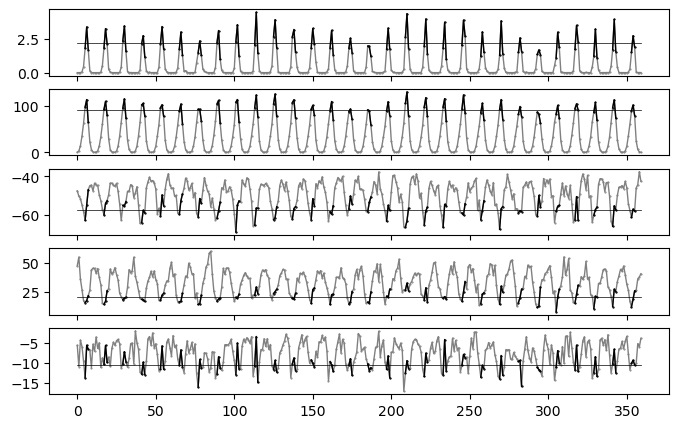

In [38]:
# Dataframe for raw data
raw_dataframe = pp.DataFrame(np.copy(data), mask=mask, var_names=var_names, datatime={0:np.arange(len(data))})
#raw_dataframe = pp.DataFrame(np.copy(data), var_names=var_names, datatime={0:np.arange(len(data))})

# Dataframe for smoothed data
smoothdataframe_here = pp.DataFrame(smoothdata_here, var_names=var_names,  datatime={0:np.arange(len(data))})

fig, axes = tp.plot_timeseries(
        raw_dataframe,
        figsize=(8, 5),
        grey_masked_samples='data',
        color='black',
        show_meanline=True,
        adjust_plot=False,
        )  

#tp.plot_timeseries(
#        smoothdataframe_here,
#        fig_axes = (fig, axes),
#        grey_masked_samples='data',
#        show_meanline=False,
#        color='red',
#        alpha=0.4,
#        adjust_plot=True,
#        tick_label_size=7,
#        label_fontsize=8,
#        time_label='Month',
#        var_units=['Gt/d', 'W/m2', 'W/m2', 'W/m2', 'W/m2'],
##         save_name="timeseries.pdf"
#        ); plt.show()

We now continue with the pre-processed data.

In [39]:
if smooth_width is not None:
    data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    data_here = np.copy(data)

data_here = anomalize(data_here, cycle_length=cycle_length)

# Initialize Tigramite dataframe with mask, missing_flag is not needed here
dataframe = pp.DataFrame(data_here, mask=mask, var_names=var_names, missing_flag=999.)
#dataframe = pp.DataFrame(data_here, var_names=var_names, missing_flag=999.)

#data_smooth = data_here

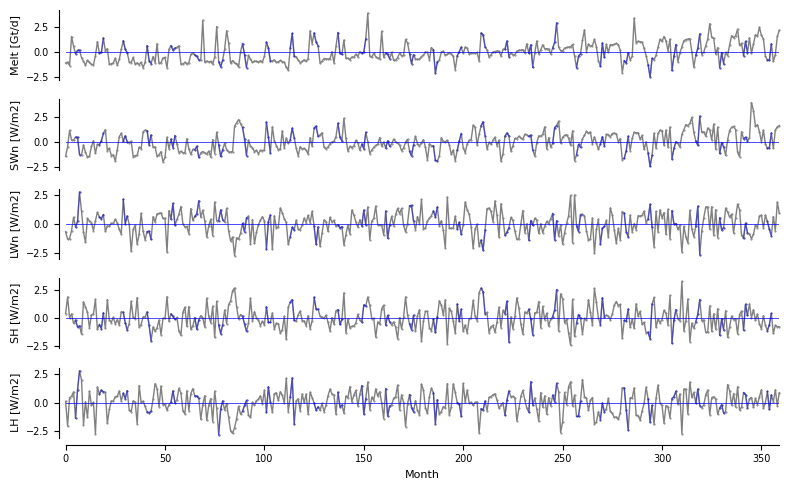

In [40]:
fig, axes = tp.plot_timeseries(
        dataframe,
        figsize=(8, 5),
        grey_masked_samples='data',
        show_meanline=True,
        color='blue',
        alpha=0.4,
        adjust_plot=True,
        tick_label_size=7,
        label_fontsize=8,
        time_label='Month',
        var_units=['Gt/d', 'W/m2', 'W/m2', 'W/m2', 'W/m2'],
#         save_name="timeseries.pdf"
        ); plt.show()

In [51]:
# Test standard deviation
std_dev = np.std(data_here[:,4])  # population standard deviation
print("Standard Deviation:", std_dev)

Standard Deviation: 1.0


### Investigating data dependencies and lag functions

To investigate the type of dependencies, we use the ``plot_scatterplots`` and  ``plot_densityplots`` functions to see whether the dependencies are really linear. With the argument ``matrix_lags`` set to a ``(N, N)`` integer numpy array you can choose which lag to use for every pair of variables. Here it is left ``None`` implying lag zero.

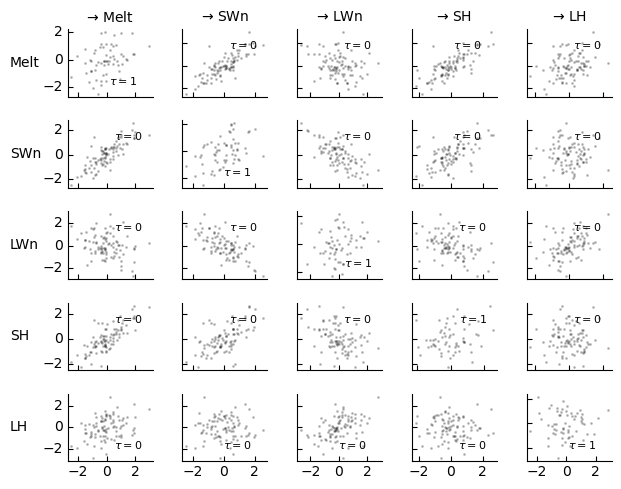

In [36]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
#matrix_lags = np.argmax(np.abs(correlations), axis=2)

# Standardize data to make it comparable
data_smooth_here = deepcopy(data_here)
mean, std = pp.weighted_avg_and_std(data_smooth_here, axis=0, weights=(mask==False))
data_smooth_here -= mean
data_smooth_here /= std

dataframe_here = pp.DataFrame(data_smooth_here, mask=mask, var_names=var_names)

tp.plot_scatterplots(dataframe=dataframe_here, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()

(The diagonal panels show the lag-zero scatter plots of variables with itself here.)

Next, we investigate kernel density estimates of the joint and marginal (diagonal panels) densities.

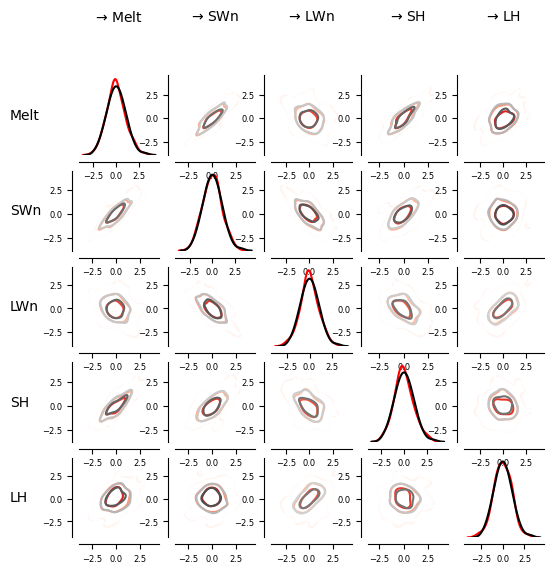

In [37]:
matrix = tp.setup_density_matrix(N=N, 
        var_names=dataframe_here.var_names, **{
        'figsize':(6, 6), 
        'tick_label_size':6,
        'label_space_left':0.18})

# Now transform data to normal marginals
data_normal = deepcopy(data_here)
data_normal = pp.trafo2normal(data_here, mask=mask)
dataframe_normal = pp.DataFrame(data_normal, mask=mask, var_names=var_names)

matrix.add_densityplot(dataframe=dataframe_here, 
    matrix_lags=matrix_lags, label_color='red', 
    snskdeplot_args = {'cmap':'Reds', 'alpha':1., 'levels':4})

matrix.add_densityplot(dataframe=dataframe_normal, 
    matrix_lags=matrix_lags, label_color='black', 
    snskdeplot_args = {'cmap':'Greys', 'alpha':1., 'levels':4})

Since in our toy model the dependencies appear reasonably linear and the distributions Gaussian, we use the ``ParCorr`` conditional independence test implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. 

Next, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations using the ``ParCorr`` class. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.
 
To this end we initialize the ``PCMCI`` method with  ``dataframe``, and ``ParCorr`` as a ``cond_ind_test``. 

In [38]:
robustparcorr = RobustParCorr(significance='analytic', mask_type='y')
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=robustparcorr,
    verbosity=1)

Before running PCMCIplus, it's a good idea to run and plot the function ``run_bivci``, which implements a bivariate, lagged conditional independence test (similar to bivariate Granger causality, but lag-specific). This can help to identify which maximal time lag ``tau_max`` to choose. Another option would be to plot ``get_lagged_dependencies``, but large autocorrelation will inflate lag peaks (see https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-13-00159.1) and ``run_bivci`` at least conditions out some part of the autocorrelation.


##
## Estimating lagged dependencies 
##

Parameters:

independence test = robust_par_corr
tau_min = 0
tau_max = 20


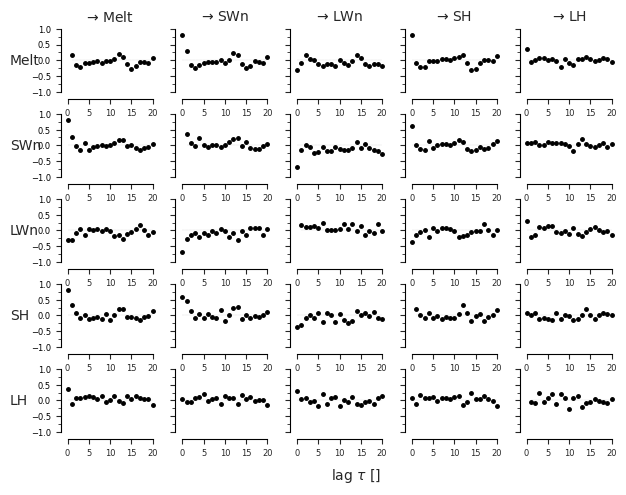

In [39]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
#correlations = pcmci.run_bivci(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

## PCMCI+ causal discovery

Here, since the dependencies in the lag function plot above decay beyond a maximum lag of around 8, we choose ``tau_max=8`` for PCMCI. The other main parameter is ``pc_alpha`` which sets the significance level in the condition-selection step. Here we let PCMCI choose the optimal value by setting it to ``pc_alpha=None``. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (e.g., ``pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]``). The parameter ``alpha_level=0.01`` indicates that we threshold the resulting p-value matrix at this significance level to obtain the graph. 

In [56]:
pcmci.verbosity = 0
results = pcmci.run_pcmciplus(tau_min=0, tau_max=12, pc_alpha=0.1, contemp_collider_rule='conservative') #reset_lagged_links=True adds more links to piControl case, not 4xext
#results = pcmci.run_pcmciplus(tau_min=0, tau_max=15, pc_alpha=0.01)

In [44]:
#print("p-values")
#print (results['p_matrix'].round(3))
#print("MCI partial correlations")
#print (results['val_matrix'].round(2))

print("Graph")
print (results['graph'])
print("Adjacency MCI partial correlations")
print (results['val_matrix'].round(2))
print("Adjacency p-values")
print (results['p_matrix'].round(3))

Graph
[[['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['-->' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['<--' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]

 [['<--' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]

 [['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['<--' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]

 [['-->' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['-->' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '

### False-discovery rate control

If we want to control for the $N^2 \tau_\max$ tests conducted here, we can further correct the p-values, e.g., by False Discovery Rate (FDR) control yielding the ``q_matrix``. The graph can then be updated with that adjusted ``p_matrix`` and a different ``alpha_level`` using ``get_graph_from_pmatrix()``.

In [95]:
#q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=15, fdr_method='fdr_bh')
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh', exclude_contemporaneous=False)
pcmci.print_significant_links(
        p_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.01, 
            tau_min=0, tau_max=15, link_assumptions=None)
results['graph'] = graph


## Significant links at alpha = 0.01:

    Variable Melt has 2 link(s):
        (SWn  0): pval = 0.00000 | val =  0.242
        (LWn  0): pval = 0.00005 | val =  0.202

    Variable SWn has 5 link(s):
        (LWn  0): pval = 0.00000 | val = -0.483
        (Melt  0): pval = 0.00000 | val =  0.242
        (SWn -1): pval = 0.00004 | val =  0.206
        (Melt -1): pval = 0.00023 | val =  0.188
        (SWn -12): pval = 0.00170 | val =  0.169

    Variable LWn has 3 link(s):
        (SWn  0): pval = 0.00000 | val = -0.483
        (SH  0): pval = 0.00000 | val = -0.461
        (Melt  0): pval = 0.00005 | val =  0.202

    Variable SH has 2 link(s):
        (LWn  0): pval = 0.00000 | val = -0.461
        (LH  0): pval = 0.00000 | val = -0.368

    Variable LH has 1 link(s):
        (SH  0): pval = 0.00000 | val = -0.368


### Further relevant methodological tutorials

The tutorial ``assumptions`` explains the underlying assumptions of causal discovery and how violations of these affect the methods.

Here we showcased ``run_pcmci`` which assumes no contemporaneous causal links. Have a look at ``run_pcmciplus`` in the corresponding tutorial ``pcmciplus`` for a method that can also detect (and account for confounding due to) contemporaneous causal links.

The tutorial ``latent-pcmci`` explains the class ``LPCMCI`` that can be used if you want to allow for hidden confounding in addition to contemporaneous links.

the tutorial ``tigramite_tutorial_jpcmciplus`` shows how to utilize multiple datasets to learn joint causal graphs and overcome some kinds of hidden confounding.

The tutorial ``conditional_independence_tests`` gives an overview of all conditional independence tests available in tigramite, including those for nonlinear and categorical variables.

The tutorial ``tigramite_tutorial_bootstrap_aggregation`` shows how bootstrap can be used for more robust causal graphs and confidence estimation of links.

The tutorial ``pcmci_fullci`` compares PCMCI with alternative estimators of vector-autoregressive models.

## Plotting

Tigramite offers several plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the ``graph`` array and optionally the ``val_matrix`` and further link attributes.

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength. Additionally, setting ``show_autodependency_lags=True`` will display the significant auto dependencies below the respective node labels.

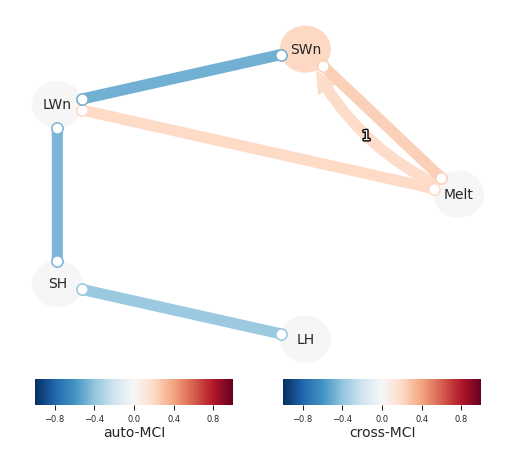

In [96]:
# with pcmci+ false-discovery rate contral
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); #plt.show()

#plt.savefig('plot/graph_pcmciplus_melt_SEB_noGHF_ARCTIC_JJA_GrIS_ablation_piControl50yr_conservative_fdrc.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

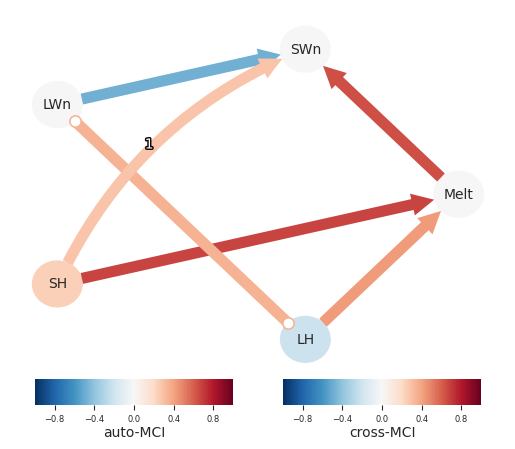

In [57]:
# without pcmci+ false-discovery rate contral
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); #plt.show()

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/MAR/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_taumax12_alpha01_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

cross-MCI: colors show the link coefficients (or edge weight) at the lag with maximum absolute link coefficient (lag label);
auto-MCI: colors depict the link coefficient of the lag-1 autocorrelation links.

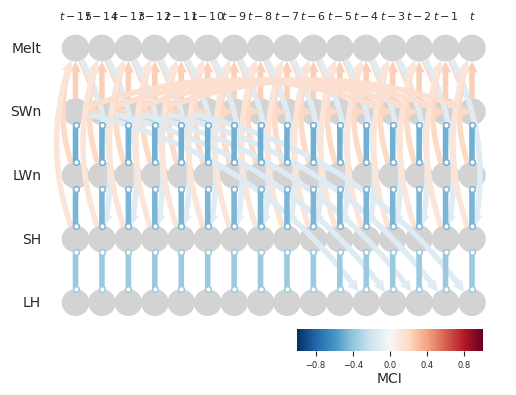

In [42]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off. You can adjust the size and aspect ratio of nodes with `node_size` and `node_aspect` parameters, and also modify many other properties, see the parameters of `plot_graph` and `plot_time_series_graph`.

Alternatively, the links can also be exported to a ``csv``-file:

## Bootstrap

### tau_max = 12

##### without seasonal cycle, max_lag=12, pc_alpha=0.01

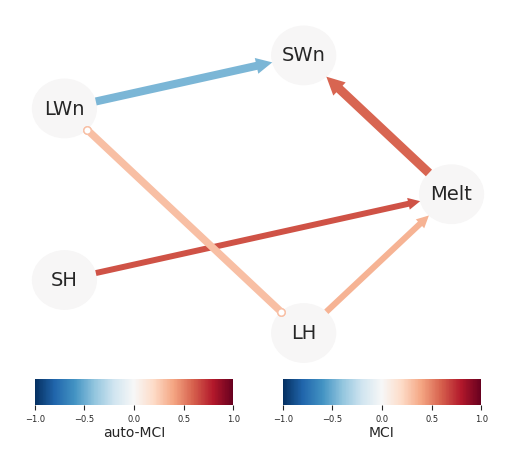

In [60]:
# alpha = 0.01
pc_alpha_bootstrap = 0.01
boot_samples = 100
tau_max = 12

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/MAR/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau12_alpha001_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

##### without seasonal cycle, max_lag=12, pc_alpha=0.025

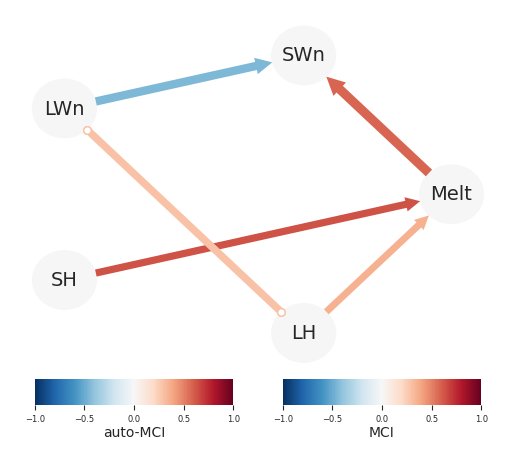

In [42]:
# alpha = 0.025
pc_alpha_bootstrap = 0.025
boot_samples = 100
tau_max = 12

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/MAR/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

In [43]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=val_mat,
    graph=boot_graph,
    var_names=dataframe.var_names,
    link_width=boot_linkfreq,
    save_name=home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv',
    digits=5,
)

In [44]:
save_name = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv'
pd.read_csv(save_name)

,Variable i,Variable j,Time lag of i,Link type i --- j,Link value,Link width
0,Melt,SWn,0,-->,0.58337,0.66
1,Melt,SH,0,<--,0.63282,0.52
2,Melt,LH,0,<--,0.35937,0.50
3,SWn,LWn,0,<--,-0.44760,0.60
4,LWn,LH,0,o-o,0.29338,0.54


In [45]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean_forplot.npz'

np.savez(save_name,
         val_matrix=val_mat,
         graph=boot_graph,
         link_width=boot_linkfreq,
         var_names=dataframe.var_names)

##### without seasonal cycle, max_lag=12, pc_alpha=0.05

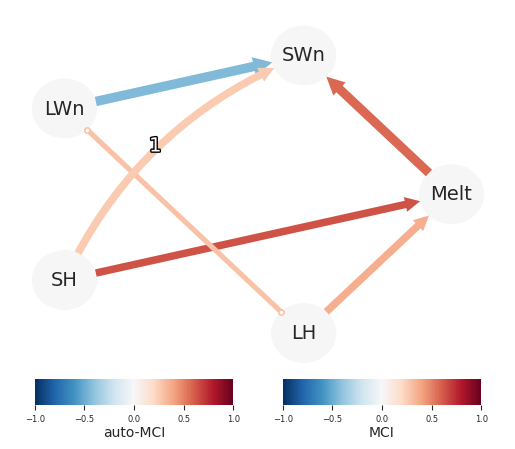

In [46]:
# alpha = 0.05
pc_alpha_bootstrap = 0.05
boot_samples = 100
tau_max = 12

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/MAR/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

In [47]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=val_mat,
    graph=boot_graph,
    var_names=dataframe.var_names,
    link_width=boot_linkfreq,
    save_name=home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv',
    digits=5,
)

In [48]:
save_name = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv'
pd.read_csv(save_name)

,Variable i,Variable j,Time lag of i,Link type i --- j,Link value,Link width
0,Melt,SWn,0,-->,0.57616,0.65
1,Melt,SH,0,<--,0.63373,0.54
2,Melt,LH,0,<--,0.36162,0.54
3,SWn,LWn,0,<--,-0.44034,0.68
4,LWn,LH,0,o-o,0.29394,0.37
5,SH,SWn,1,-->,0.26111,0.55


In [49]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean_forplot.npz'

np.savez(save_name,
         val_matrix=val_mat,
         graph=boot_graph,
         link_width=boot_linkfreq,
         var_names=dataframe.var_names)

##### without seasonal cycle, max_lag=12, pc_alpha=0.1

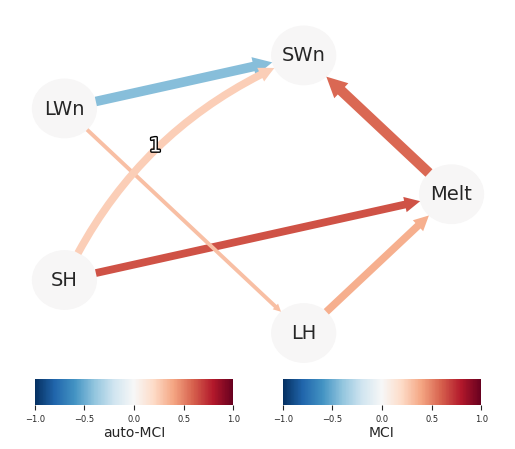

In [50]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 12

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/MAR/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

In [41]:
val_mat.shape

(5, 5, 13)

In [38]:
boot_graph[0,:,:]

array([['', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['-->', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['<--', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['<--', '', '', '', '', '', '', '', '', '', '', '', '']],
      dtype='<U3')

In [39]:
np.where(boot_graph != '', val_mat, np.NaN)[0,:,:]

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [0.57715434,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [0.63741261,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [0.36083073,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan]])

In [51]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=val_mat,
    graph=boot_graph,
    var_names=dataframe.var_names,
    link_width=boot_linkfreq,
    save_name=home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv',
    digits=5,
)

In [52]:
save_name = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv'
pd.read_csv(save_name)

,Variable i,Variable j,Time lag of i,Link type i --- j,Link value,Link width
0,Melt,SWn,0,-->,0.57715,0.74
1,Melt,SH,0,<--,0.63741,0.56
2,Melt,LH,0,<--,0.36083,0.54
3,SWn,LWn,0,<--,-0.42399,0.69
4,LWn,LH,0,-->,0.30237,0.28
5,SH,SWn,1,-->,0.24519,0.55


In [53]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean_forplot.npz'

np.savez(save_name,
         val_matrix=val_mat,
         graph=boot_graph,
         link_width=boot_linkfreq,
         var_names=dataframe.var_names)

##### without seasonal cycle, max_lag=12, pc_alpha=None

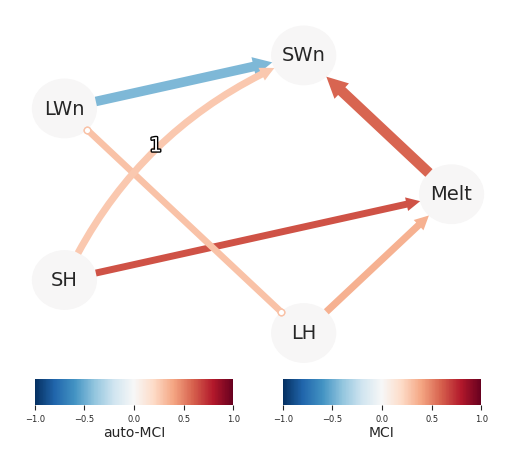

In [54]:
# alpha = None
pc_alpha_bootstrap = None
boot_samples = 100
tau_max = 12

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/MAR/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

In [55]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=val_mat,
    graph=boot_graph,
    var_names=dataframe.var_names,
    link_width=boot_linkfreq,
    save_name=home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv',
    digits=5,
)

In [56]:
save_name = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv'
pd.read_csv(save_name)

,Variable i,Variable j,Time lag of i,Link type i --- j,Link value,Link width
0,Melt,SWn,0,-->,0.57934,0.76
1,Melt,SH,0,<--,0.63392,0.50
2,Melt,LH,0,<--,0.35753,0.51
3,SWn,LWn,0,<--,-0.44655,0.69
4,LWn,LH,0,o-o,0.29367,0.47
5,SH,SWn,1,-->,0.27252,0.51


In [57]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean_forplot.npz'

np.savez(save_name,
         val_matrix=val_mat,
         graph=boot_graph,
         link_width=boot_linkfreq,
         var_names=dataframe.var_names)

### tau_max = 6

##### without seasonal cycle, max_lag=6, pc_alpha=0.1

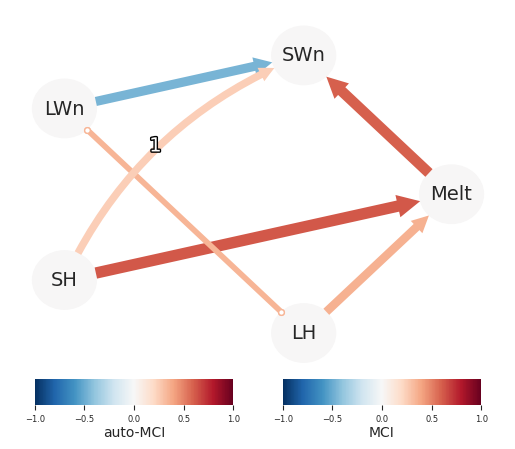

In [40]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 6

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/MAR/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

### tau_max = 18

##### without seasonal cycle, max_lag=18, pc_alpha=0.1

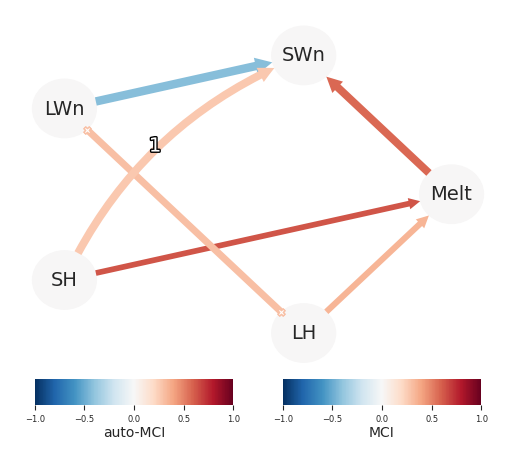

In [41]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 18

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/MAR/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

### tau_max = 5

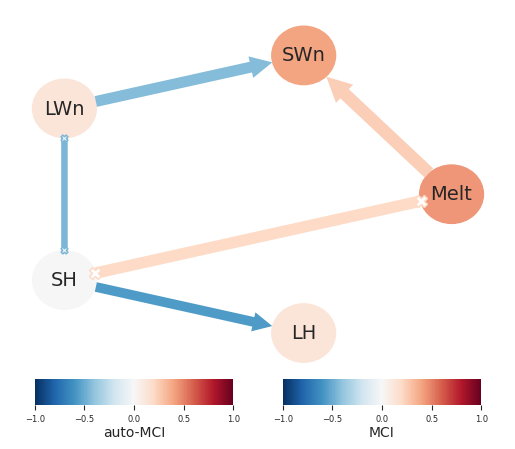

In [43]:
# alpha = 0.01
pc_alpha_bootstrap = 0.01
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alpha001_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

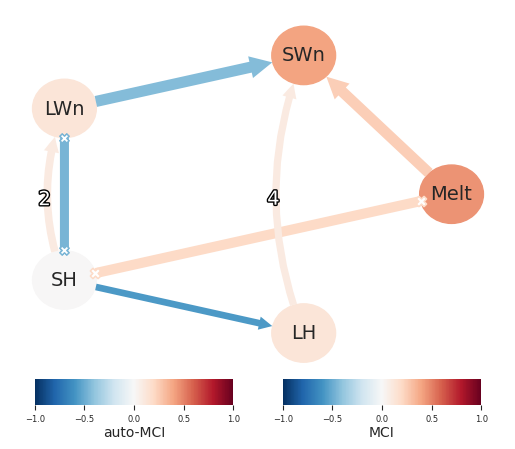

In [44]:
# alpha = 0.025
pc_alpha_bootstrap = 0.025
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alpha0025_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

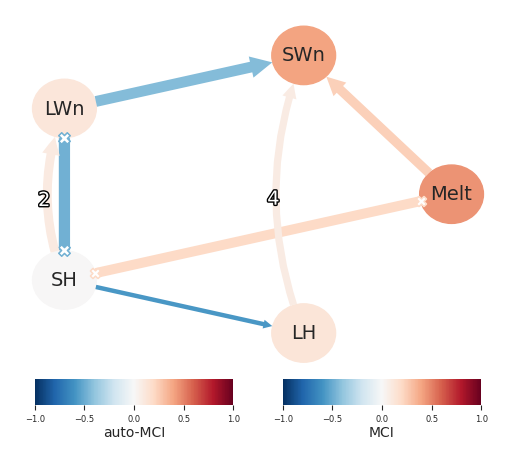

In [45]:
# alpha = 0.05
pc_alpha_bootstrap = 0.05
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alpha005_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

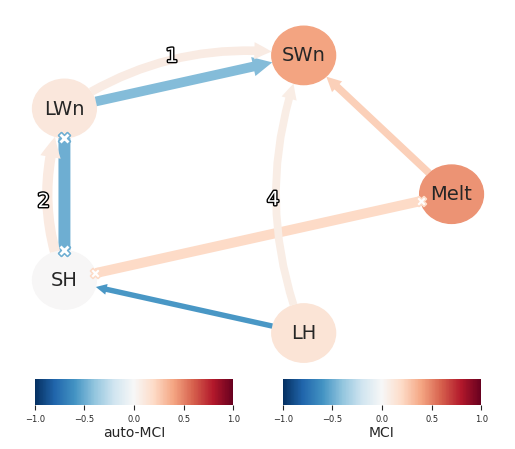

In [46]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alpha01_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

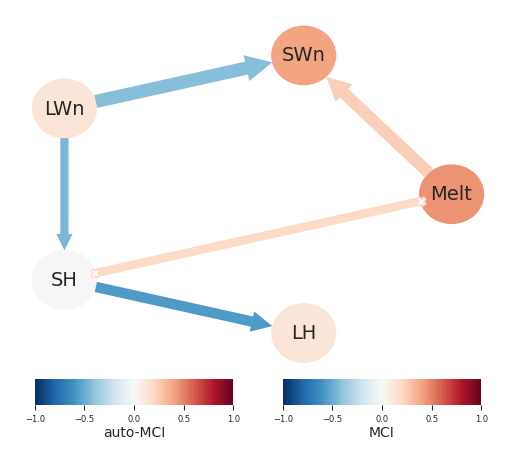

In [47]:
# alpha = None
pc_alpha_bootstrap = None
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alphaNone_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

### cond_ind_test=robustparcorr, tau_max = 15

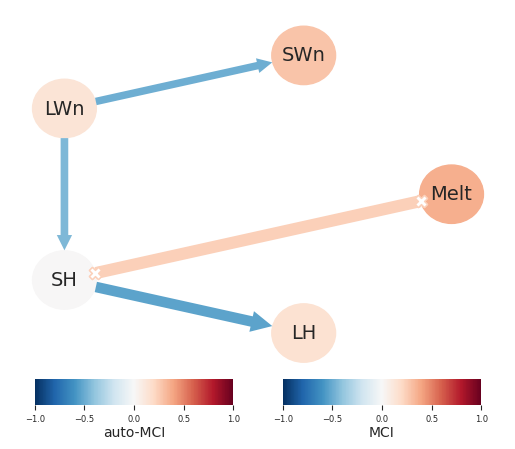

In [52]:
# alpha = 0.01
pc_alpha_bootstrap = 0.01
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alpha001_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

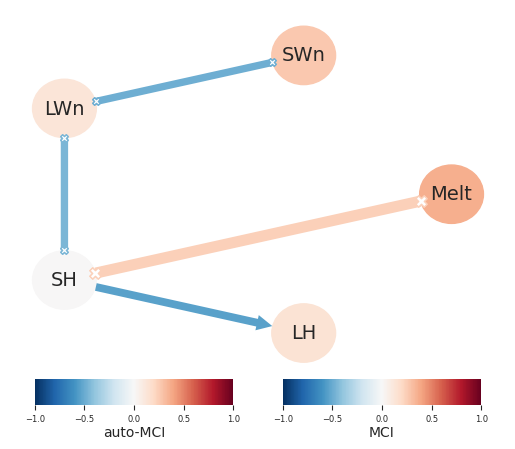

In [53]:
# alpha = 0.025
pc_alpha_bootstrap = 0.025
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alpha0025_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

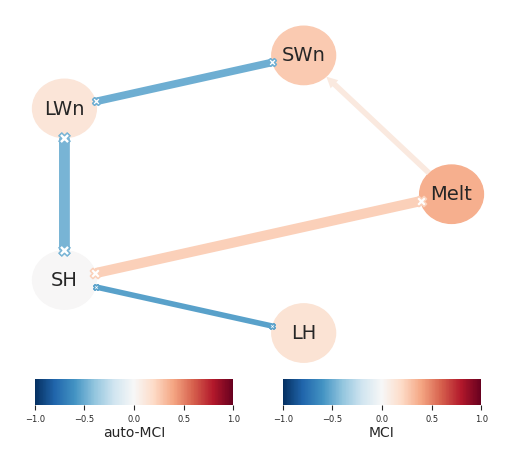

In [54]:
# alpha = 0.05
pc_alpha_bootstrap = 0.05
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alpha005_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

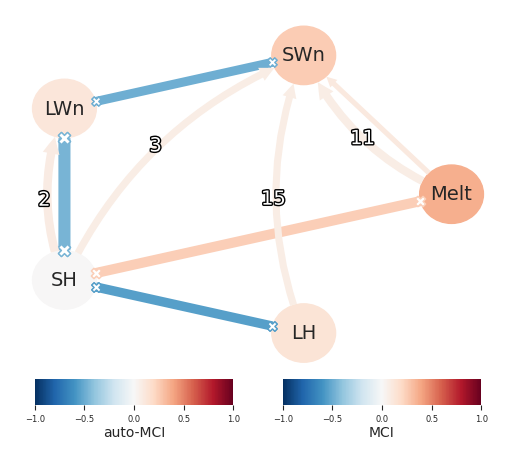

In [55]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alpha01_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

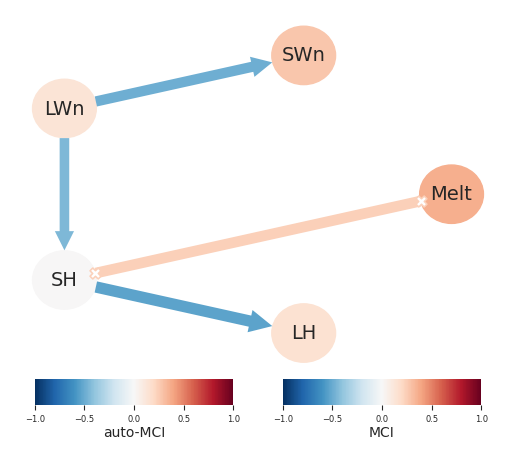

In [56]:
# alpha = None
pc_alpha_bootstrap = None
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alphaNone_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

### cond_ind_test=gpdc, tau_max = 15

Couldn't finish with bootstrap

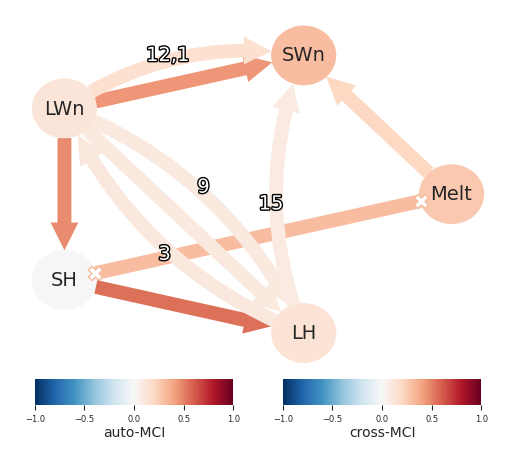

In [66]:
## alpha = 0.05

# Create PCMCI object
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=gpdc,
        verbosity=0,
        )

# Run pcmciplus
results = pcmci.run_pcmciplus(tau_min=0, tau_max=15, pc_alpha=0.05, contemp_collider_rule='conservative') #reset_lagged_links=True adds more links to piControl case, not 4xext

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_gpdc_conservative_nofdrc.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)